In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from glob import glob

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sbibm
import sbi.analysis as analysis
from sbibm.utils.io import get_tensor_from_csv

from notebookutils import *

## description
big basic runs, no extra_theta  
/home/ben/sci/cnre/benchmarking/multirun/2022-04-06/06-11-48   
/home/ben/sci/cnre/benchmarking/multirun/2022-04-06/06-14-11   

big run, failed some extra_theta  
/home/ben/sci/cnre/benchmarking/multirun/2022-04-06/19-42-08  

5 tasks extra_theta = 10  
/home/ben/sci/cnre/benchmarking/multirun/2022-04-06/16-14-02  

5 tasks extra_theta = 0, 20 (goal is to see if the reason the c2st got worse with extra theta was due to differences in training samples 001 vs 010)  
/home/ben/sci/cnre/benchmarking/multirun/2022-04-07/14-48-01  

lots of gaussian_mixture runs, extra_theta = 10, 20  
/home/ben/sci/cnre/benchmarking/multirun/2022-04-07/12-00-58  

cnre with 1_000 simulations and [10, 20] extra_theta_factor  
/home/ben/sci/cnre/benchmarking/multirun/2022-04-08 

nre with 1_000 simulations and 0 extra_theta_factor, also cnre with the same  
/home/ben/sci/cnre/benchmarking/multirun/2022-04-12 

In [27]:
files = [
    # "metrics-0406.csv", 
    "metrics.csv", 
    "metrics-small.csv", 
]
df = pd.concat([pd.read_csv(file, index_col=0) for file in files], ignore_index=True)
df["training_samples_id"] = df["training_samples_root"].map(get_training_samples_id)
print(len(df))
df.head()

warning!
warning!
warning!
warning!
warning!
warning!
warning!
warning!
warning!
warning!
1701


,task,num_simulations,num_observation,seed,max_num_epochs,algorithm,num_atoms,gamma,extra_theta_factor,training_samples_root,...,MMD,MMD_Z,MEDDIST,NLTP,AVG_LOG_RATIO,RT,num_simulations_simulator,path,folder,training_samples_id
0,gaussian_mixture,100000,1,1746250354,300,CNRE,75,100.00,20,extra/010,...,0.083324,0.081130,1.052960,NaN,12.399643,327.643197,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,49,10
1,gaussian_mixture,100000,1,1224805732,300,CNRE,50,0.10,10,extra/010,...,0.053787,0.049382,1.035793,NaN,9.747178,294.250911,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,32,10
2,gaussian_mixture,100000,2,2296748511,300,CNRE,25,0.01,20,extra/010,...,0.017185,0.015956,1.044628,NaN,9.180038,303.838053,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,71,10
3,gaussian_mixture,100000,2,1299984277,300,CNRE,50,0.10,20,extra/010,...,0.014575,0.012991,0.849172,NaN,9.937567,321.064779,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,83,10
4,gaussian_mixture,100000,2,4055182025,300,CNRE,2,0.10,20,extra/010,...,0.023028,0.021836,1.073073,NaN,5.707378,288.163249,100000.0,/home/ben/sci/cnre/benchmarking/multirun/2022-...,53,10


In [31]:
df.columns

Index(['task', 'num_simulations', 'num_observation', 'seed', 'max_num_epochs',
       'algorithm', 'num_atoms', 'gamma', 'extra_theta_factor',
       'training_samples_root', 'C2ST', 'C2ST_Z', 'MMD', 'MMD_Z', 'MEDDIST',
       'NLTP', 'AVG_LOG_RATIO', 'RT', 'num_simulations_simulator', 'path',
       'folder', 'training_samples_id'],
      dtype='object')

In [28]:
# df = df[df["num_simulations"] == 1_000]

In [29]:
print(
    df["algorithm"].unique(),
    df["task"].unique(),
    df["extra_theta_factor"].unique(),
    df["gamma"].unique(),
    df["num_simulations"].unique(),
)

['CNRE' 'NRE-B'] ['gaussian_mixture' 'slcp' 'two_moons' 'gaussian_linear_uniform'
 'slcp_distractors'] [20 10  0] [1.e+02 1.e-01 1.e-02 1.e+01 1.e+00    nan] [100000   1000]


## extract the ones with extra theta (and comparisons)

In [7]:
# dfextra = df[df["path"].map(lambda x: "/home/ben/sci/cnre/benchmarking/multirun/2022-04-06/16-14-02" in x)]
dfextra = df[df["path"].map(lambda x: "/home/ben/sci/cnre/benchmarking/multirun/2022-04-06/16-14-02" in x or "/home/ben/sci/cnre/benchmarking/multirun/2022-04-07/14-48-01/" in x)]
dfextra = dfextra.sort_values(["task", "extra_theta_factor"])
print(dfextra[["task", "extra_theta_factor", "C2ST_Z"]])

Empty DataFrame
Columns: [task, extra_theta_factor, C2ST_Z]
Index: []


and remove the non extra_theta ones
... and the corresponding other ones

In [8]:
# df = df[df["path"].map(lambda x: "/home/ben/sci/cnre/benchmarking/multirun/2022-04-06/16-14-02" not in x)]
# df = df[df["path"].map(lambda x: "/home/ben/sci/cnre/benchmarking/multirun/2022-04-06/19-42-08" not in x)]
dfnotextra = df[df["extra_theta_factor"] == 0]
len(dfnotextra)

g = dfnotextra.groupby(["algorithm", "num_observation", "num_atoms", "gamma", "training_samples_id", "task"])
g.groups

l = []
for task in df["task"].unique().tolist():
    try:
        l.append(
            g.get_group(("CNRE", 1, 75, 1.0, 1, task))
        )
    except KeyError:
        pass

dfcompare = pd.concat(l).sort_values("task")
dfcompare

ValueError: No objects to concatenate

In [9]:
cols = ["task", "training_samples_root", "C2ST_Z", "extra_theta_factor"]
print(dfcompare[cols].sort_values("task"))
print(dfextra[cols].sort_values("task"))

NameError: name 'dfcompare' is not defined

## cnre run times

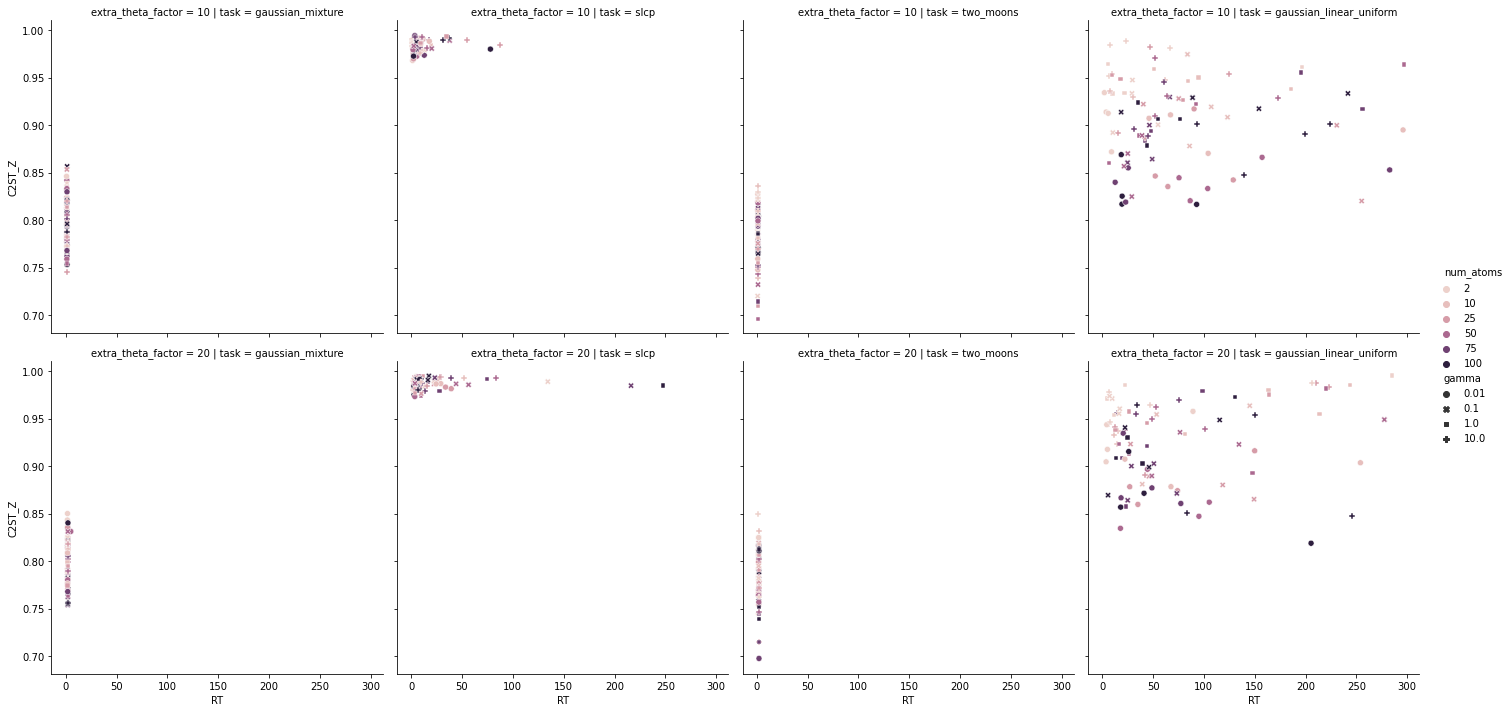

In [10]:
# Run times
dfcnre = df[df["algorithm"] == "CNRE"]
sns.relplot(
    data=dfcnre, 
    x="RT",
    y="C2ST_Z",
    style="gamma", 
    # hue="algorithm", 
    hue="num_atoms",
    col="task",
    row="extra_theta_factor",
    # kind="line",
)

## cnre quality

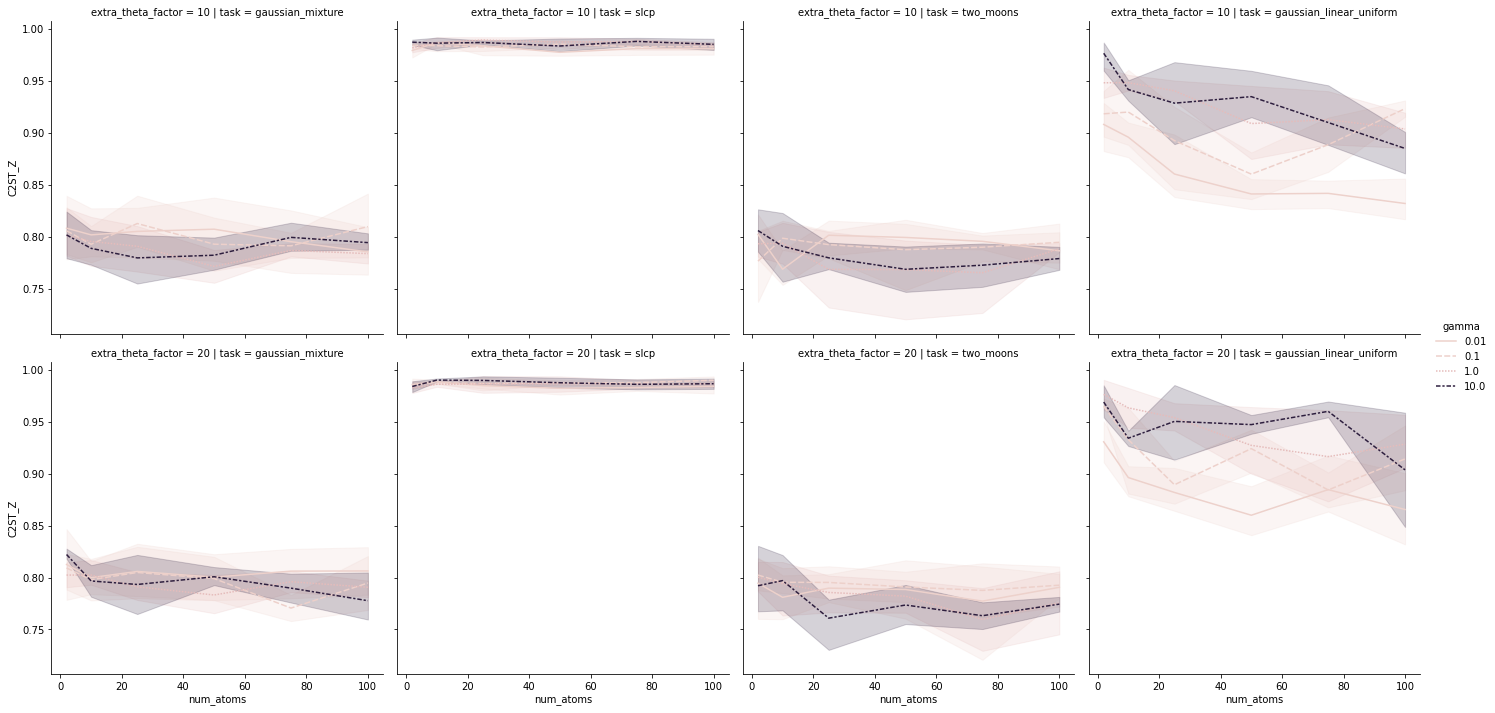

In [11]:
# quality
dfcnre = df[df["algorithm"] == "CNRE"]
sns.relplot(
    data=dfcnre, 
    x="num_atoms", 
    y="C2ST_Z", 
    style="gamma", 
    # hue="algorithm", 
    hue="gamma",
    col="task",
    row="extra_theta_factor",
    kind="line",
)

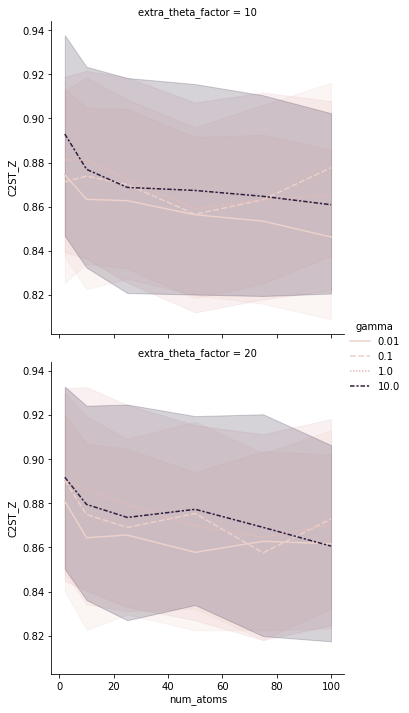

In [12]:
# quality
sns.relplot(
    data=dfcnre, 
    x="num_atoms", 
    y="C2ST_Z", 
    style="gamma", 
    # hue="algorithm", 
    hue="gamma",
    # col="task",
    row="extra_theta_factor",
    kind="line",
)

## num atoms

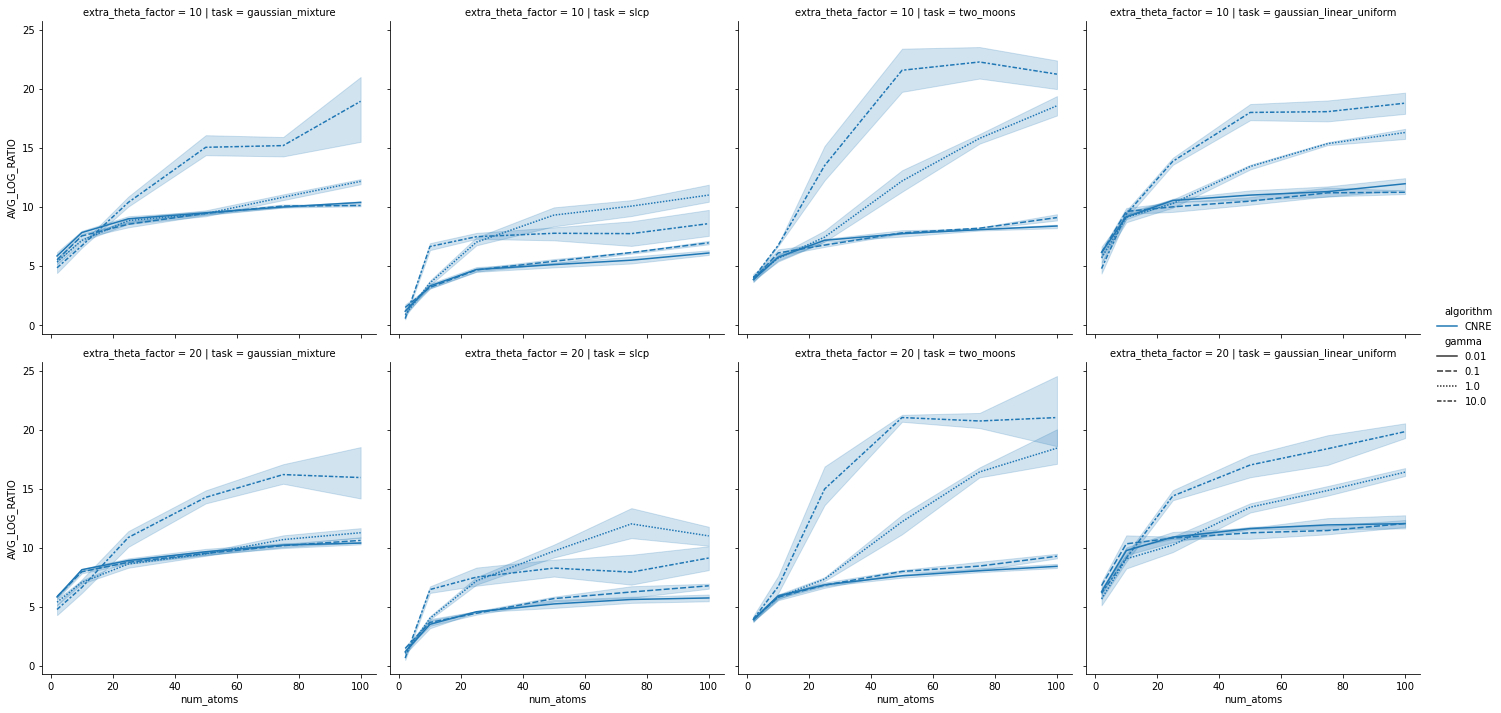

In [13]:
sns.relplot(
    data=df.fillna(1.0), 
    x="num_atoms", 
    y="AVG_LOG_RATIO", 
    style="gamma", 
    hue="algorithm", 
    col="task",
    row="extra_theta_factor",
    # row="num_observation",
    kind="line",
    # row="task",
)

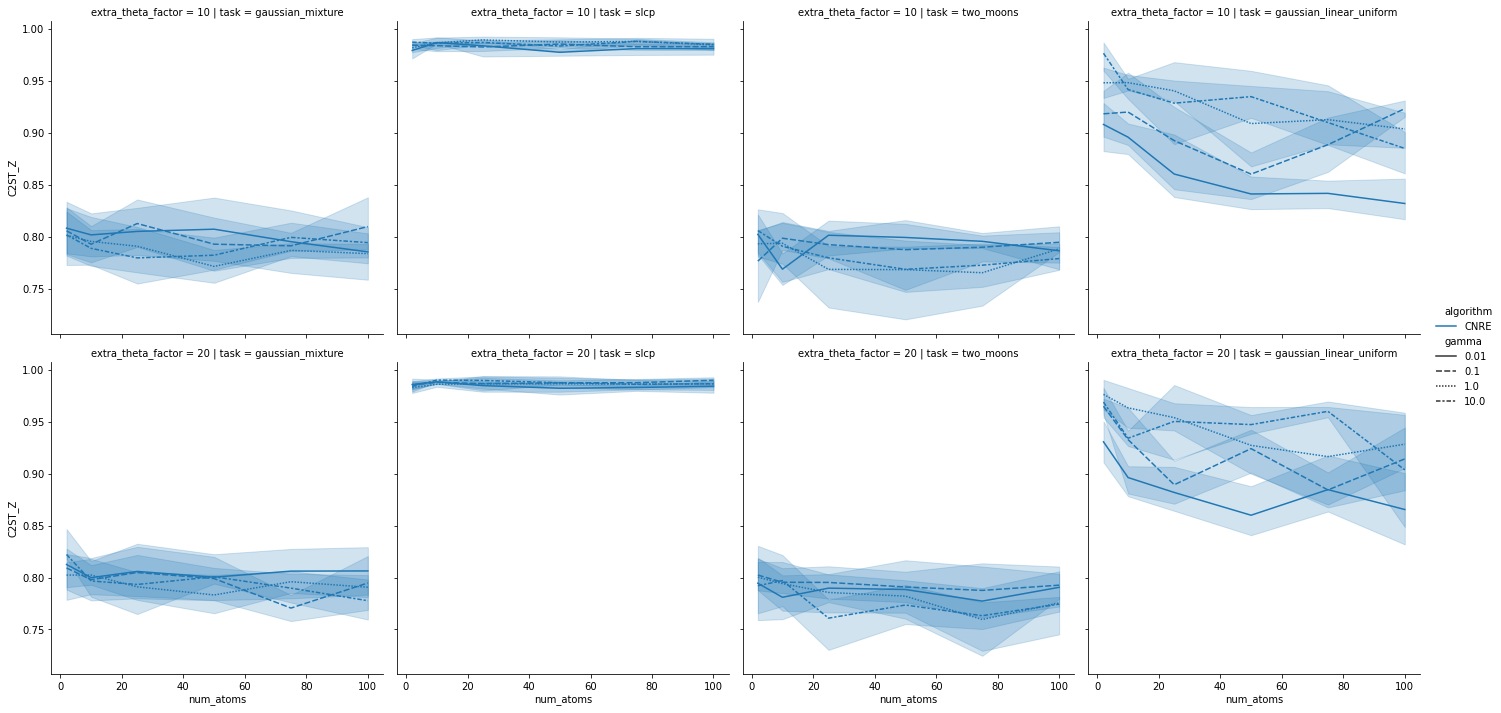

In [14]:
df_ = df
df_.loc[:, "gamma"] = df_.loc[:, "gamma"].fillna(1.0)
sns.relplot(
    data=df_, 
    x="num_atoms", 
    y="C2ST_Z", 
    style="gamma", 
    hue="algorithm", 
    col="task",
    row="extra_theta_factor",
    # row="num_observation",
    kind="line",
    # row="task",
)

## correlate the negative avg log ratio (estimated kld) with the c2st

In [15]:
df_ = df[(df["algorithm"] == "CNRE") & (df["extra_theta_factor"] == 0)]
df_.loc[:, "NEG_AVG_LOG_RATIO"] = - dfcorrl["AVG_LOG_RATIO"]
sns.relplot(
    data=df_, 
    x="NEG_AVG_LOG_RATIO",
    y="C2ST_Z", 
    style="gamma", 
    # hue="algorithm", 
    col="task",
    # row="extra_theta_factor",
    # row="num_observation",
    # kind="line",
    # row="task",
)

NameError: name 'dfcorrl' is not defined

## talk

- Is it possible to get a better posterior with higher K? ... one (most basic) test of the algorithm without bootstrap: give it as much data as it needs (always sample) see how it converges
- How much info can we squeeze out of a fixed dataset? (on this case show the validation loss curve)
    - testing a limited x case: give a restricted number of xs. sample theta as much as we want
    - testing with fixed x and theta: the current method of bootstrapping vs computing each of K terms / (sample y and see how long it takes for different Ks to converge.)
    - (Train 2 class estimator until convergence, does adding new classes make it better?)
- What is the relevant convergence speed by changing K? (what does speed actually mean) "convergence speed" how fast can we go in time or data 

GOAL: are we extracting more information out of the data with K classes or are we just "bootstrapping" smartly?

**no limit to the amount of data**  
experiment 1a: draw x and theta as much as necesssary with different Ks and different gammas see where they saturate. (make a same scale plot of validation loss vs {RT, how many xs the loss fn saw})  
experiment 1b: do the above, but sample y.  

**completely fixed x theta pairs**  
experiment 2 (doneish): fixed number of epochs 300. use every x twice. resample theta a lot  
experiment 3: maximum bootstrap, use x and theta as much as you want to compute the loss terms  

**fixed x theta pairs AND allowed to redraw thetas**  
experiment 4: use the pairs as you need but redraw thetas.

Possible selling points:
- better test error
- less simulator runs
- literally faster

**sequential case**  
intially draw from the prior. let the mcmc "burn in." then the different ks have info about whether the pair is drawn from the prior joint / posterior joint

## specific

In [ ]:
# g = dfnotextra.groupby(["algorithm", "num_observation", "num_atoms", "gamma", "training_samples_id", "task"])
# g.groups
df_ = df[df["extra_theta_factor"] == 0]
g = df_.groupby(["num_observation", "num_atoms", "task"])
df_ = g.get_group((1, 2, 'gaussian_mixture'))
df_ = df_[df_["training_samples_id"] == 1]
df_ = pd.concat([
    df_[df_["algorithm"] == "NRE-B"],
    df_[(df_["algorithm"] == "CNRE") & (df_["gamma"] == 0.01)],
])

for i, row in df_.iterrows():
    true_theta=get_true_theta_from_row(row)
    p = get_relative_path(row["path"])
    p = get_posterior_samples(p)
    plot_posterior(p, true_theta=true_theta, name=f"{row['algorithm']} {row['C2ST_Z']}")

r = get_reference_samples_from_row(row)
plot_posterior(r, true_theta=true_theta)

In [ ]:
print(df.loc[0, "C2ST_Z"])
p = get_relative_path(df.loc[0, "path"], "saverun/two_moons-slcp/", "/home/ben/sci/cnre/benchmarking/multirun/2022-04-01/")
p = get_posterior_samples(p)
plot_posterior(p)

In [ ]:
dfrel = df[
    (df["num_atoms"] == 75) &
    (df["task"] != "gaussian_mixture")
]
idx = 4
row = dfrel.iloc[idx]
p = get_relative_path(row["path"], "saverun/two_moons-slcp/", "/home/ben/sci/cnre/benchmarking/multirun/2022-04-01/")

plt.semilogy(get_validation_losses(p).numpy())

In [ ]:
dfgm = df[df["task"] == "gaussian_mixture"]

idx = 0
row = dfgm.iloc[idx]
true_theta=get_true_theta_from_row(row)

print(row["C2ST_Z"])
p = get_relative_path(row["path"], "/home/ben/sci/cnre/benchmarking/multirun/")
print(p)
p = get_posterior_samples(p)
plot_posterior(p, true_theta=true_theta)

r = get_reference_samples_from_row(row)
plot_posterior(r, true_theta=true_theta)

In [ ]:
row

In [ ]:
import torch
task = sbibm.get_task("gaussian_mixture")
num_observation = 3
true_theta = task.get_true_parameters(num_observation)
sbibm_obs = task.get_observation(num_observation)
new_obs = task.get_simulator()(true_theta)
obss = torch.concat([task.get_simulator()(true_theta) for _ in range(100)])
print(true_theta)
print(
    (torch.linalg.norm(sbibm_obs - obss)).mean(),
    (torch.linalg.norm(new_obs - obss)).mean(),
)

In [ ]:
a = get_tensor_from_csv("/home/ben/sci/cnre/benchmarking/multirun/2022-04-02/18-02-23/0/validation_losses.csv.bz2").numconcatplt.plot(a)